In [ ]:
# Импорт необходимых библиотек для монтирования диска
import os

#==монтирование google drive в colab и просмотр содержимого dataset
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Data/docs_ds/

Mounted at /content/drive
/content/drive/My Drive/Data/docs_ds


In [ ]:
!pip install colorama

**1. Настройка**

***1.1 Импорт и конфигурирование библиотек***

In [ ]:
# Библиотеки для обработки данных
import numpy as np
import pandas as pd
import spacy

# Библиотеки для визуализации данных
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

# Служебные библиотеки
import re
from tqdm import tqdm
from colorama import Fore, Style


# Получение версий библиотек
print("Версия NumPy:", np.__version__)
print("Версия Spacy:", spacy.__version__)
print("Версия Pandas:", pd.__version__)
print("Версия Matplotlib:", matplotlib.__version__)
print("Версия Seaborn:", sns.__version__)

# Конфигурирование NumPy.
# Установка атрибута `Line width` на максимальное значение 130 символов при выводе.
# После 130 символов вывод продолжится со следующей строки.
np.set_printoptions(linewidth=130)

# Уонфигурирование Seaborn.
sns.set_style("whitegrid")  # Установка фона белого цвета и сетки.
sns.set_palette("deep")  # Установка цветовой палитры.
sns.set_context("paper", font_scale=1.25)  # Установка размера шрифта на 1.25 больше обычного.

Версия NumPy: 2.0.2
Версия Spacy: 3.8.11
Версия Pandas: 2.2.2
Версия Matplotlib: 3.10.0
Версия Seaborn: 0.13.2


***1.2 Задание констант и вспомогательных (служебных) функций***

In [ ]:
# Константы.
DOCS_FOLDER = '/content/drive/My Drive/Data/docs_ds'
METADATA_CSV = "/content/drive/My Drive/Data/preprocessed/metadata.csv"
PARSED_TEXT_CSV = "/content/drive/My Drive/Data/preprocessed/parsed_text.csv"
DOCS_CSV = "/content/drive/My Drive/Data/preprocessed/preprocessed.csv"


In [ ]:
# Вспомогательные функции

#===Функция проверки, не является ли вводимый элемент пустым
def func_isEmpty(el_loc):
    if (isinstance(el_loc, int) or isinstance(el_loc, float)) and el_loc == 0:
        # Исключение 0 и 0.0 из множества пустых значений
        return False
    elif isinstance(el_loc, str) and len(el_loc.strip()) == 0:
        # Включение в множество пустых значений строку, содержащую только один и более пробелов
        return True
    elif isinstance(el_loc, bool):
        # Исключение значения False из множества пустых значений
        return False
    else:
        return False if el_loc else True

#===Функция для вывода списка всех дублирующихся идентификаторов документов
def func_DupDocIds(dataframe_loc):
  return [idx for idx, val in dataframe_loc["ID"].value_counts().items() if val > 1]

#===Функция формирования корреляционной матрицы
def func_getCorrMat(dataframe_loc, target_loc):
    """
    Возвращаемые значения:
        1. Корреляционная матрица, отсортированная по целевому значению в порядке убывания.
        2. Обнуление дисперсии случайных величин.
    """
    res_correlation_matrix = dataframe_loc.corr(numeric_only=True)
    for col_curr in res_correlation_matrix.columns.tolist():
        # Обнуление дисперсии.
        res_correlation_matrix.loc[col_curr, col_curr] = 0

    return res_correlation_matrix.drop(target_loc).sort_values(by=target_loc, ascending=False)


# Преобразование списка уникальных элементов в словарь (значение = индекс, ключ = элемент)
toDictionary = lambda frm_list: {item: frm_list.index(item) for item in frm_list}


In [ ]:
# Функции для отрисовки различных графических зависимостей

#===Функция вывода данных в виде таблицы
def func_plotAsTable(headers_loc, rows_loc, align="l", add_sl_no=False):
    if isinstance(rows_loc, pd.Series):
        rows_loc = list(rows_loc.iteritems())

    res_table = PrettyTable(align=align)

    if add_sl_no:
        res_table.field_names = ["Номер типа"] + list(headers_loc)
        res_table.align["Номер типа"] = "r"
        rows = [[idx + 1] + list(row_curr) for idx, row_curr in enumerate(rows_loc)]
    else:
        res_table.field_names = headers_loc

    res_table.add_rows(rows)
    display(res_table)

#===Функция отрисовки график
def func_drawElbow(ll_loc, hl_loc, columnName_loc, dataframe_loc, y_label_loc):
    plt.figure(figsize=(4, 3))

    pts = dataframe_loc[columnName_loc].quantile(q=np.arange(ll_loc, hl_loc, 0.01))
    sns.lineplot(x=pts.index, y=pts)
    plt.title(f"{y_label_loc} b/w {ll_loc} & {round(hl_loc - 0.01, 2)} процентиль")
    plt.xlabel("Процентиль")
    plt.ylabel(y_label_loc)

    plt.show()

***1.3 Метаданные***

Извлечение и сохранение метаданных из файлов документов. Метаданные, содержат поля:

Тип документа: Метка класса, взятая из имени папки, содержащей документы.  
Идентификатор документа: Генерируется на основе первого символа типа документа и имени файла.  
Размер файла: Размер файла в байтах.  
Путь к файлу: Относительный путь к файлу.

In [ ]:
if os.path.exists(METADATA_CSV):
    print("Загрузка метаданных из:", METADATA_CSV)
    res_meta_dataframe = pd.read_csv(METADATA_CSV)
else:
    res_meta_data = []
    folders = os.listdir(DOCS_FOLDER)
    for folder_name in folders:
        folder_path = os.path.join(DOCS_FOLDER, folder_name)
        if not os.path.isdir(folder_path):
            continue

        file_names = os.listdir(folder_path)
        for file_full_name in file_names:
            file_full_path = folder_path + "/" + file_full_name

            # Получение размера файла, используя его полный путь.
            file_size = os.path.getsize(file_full_path)

            # Получение имени и расширения файла.
            file_name, ext = os.path.splitext(file_full_name)

            # Создание уникального идентификатора документа для последующего использования.
            file_id = folder_name[0].upper() + "_" + file_name

            res_meta_data.append([folder_name.capitalize(), file_id, file_size, file_full_path])

    # Преобразование списка метаданных документов в DataFrame.
    col_names = ["Тип", "ID", "Размер", "Путь"]
    res_meta_dataframe = pd.DataFrame(data=res_meta_data, columns=col_names)

    # Сохранение DataFrame в csv файл для последующего применения.
    res_meta_dataframe.to_csv(METADATA_CSV, index=False, na_rep="")
    print("Метеданные сохранены в:", METADATA_CSV)

# Изменение типа данных столбца "Тип" со строкового на категориальный.
res_meta_dataframe["Тип"] = res_meta_dataframe["Тип"].astype("category")

res_meta_dataframe.sample(3)


Загрузка метаданных из: /content/drive/My Drive/Data/preprocessed/metadata.csv


,Тип,ID,Размер,Путь
605,Restricted,R_216,3072,/content/drive/My Drive/Data/docs_ds/restricte...
349,Public,P_236,1996,/content/drive/My Drive/Data/docs_ds/public/23...
1136,Confidential,C_222,1852,/content/drive/My Drive/Data/docs_ds/confident...


**2. EDA (Метаданные документа)¶**

In [ ]:
# Статистика загруженного набора данных.
rows, cols = res_meta_dataframe.shape
print(f"Набор данных содержит {rows} строк и {cols} столбцов.\n")

res_meta_dataframe.info()

Набор данных содержит 1218 строк и 4 столбцов.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Тип     1218 non-null   category
 1   ID      1218 non-null   object  
 2   Размер  1218 non-null   int64   
 3   Путь    1218 non-null   object  
dtypes: category(1), int64(1), object(2)
memory usage: 30.1+ KB


***2.1 Проверка дубликатов***

In [ ]:
# Проверка наличия дубликатов поля "ID" для всех типов документов.
duplicate_document_ids = func_DupDocIds(res_meta_dataframe)
print(len(duplicate_document_ids), "`IDs встречаются в наборе данных более одного раза.")

0 `IDs встречаются в наборе данных более одного раза.


***2.2 Метка типа документа: столбец 'Тип'***

In [ ]:
typess_count = res_meta_dataframe["Тип"].value_counts()

func_plotAsTable(
    headers_loc=["Метка типа", "Количество"],
    rows_loc=list(zip(types_count.index, types_count.values)),
    add_sl_no=True,
)

NameError: name 'res_meta_dataframe' is not defined

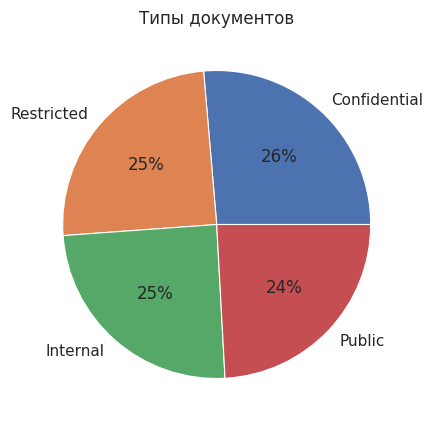

In [ ]:
# Круговая диаграмма распределения типов документов в общем наборе данных.
plt.figure(figsize=(5, 5))

plt.pie(x=types_count, labels=types_count.index, autopct="%1.0f%%")
plt.title("Типы документов")

plt.show()

***2.3 Новый столбец: 'Категория' (цифровой код типа документа)***

In [ ]:
# Кодирование столбца 'Тип' в новом столбце 'Категория'. Он используется в качестве метки типа (класса) при моделировании
codes, uniques = pd.factorize(res_meta_dataframe["Тип"])

print(uniques)
res_meta_dataframe.head(5)

CategoricalIndex(['Internal', 'Public', 'Restricted', 'Confidential'], categories=['Confidential', 'Internal', 'Public', 'Restricted'], ordered=False, dtype='category')


,Тип,ID,Размер,Путь
0,Internal,I_219,1402,/content/drive/My Drive/Data/docs_ds/internal/...
1,Internal,I_196,2508,/content/drive/My Drive/Data/docs_ds/internal/...
2,Internal,I_205,2312,/content/drive/My Drive/Data/docs_ds/internal/...
3,Internal,I_215,2195,/content/drive/My Drive/Data/docs_ds/internal/...
4,Internal,I_203,3052,/content/drive/My Drive/Data/docs_ds/internal/...


In [ ]:
types_map = toDictionary(uniques.categories.to_list())
print("Закодированные метки классов (типов):\n", types_map)

res_meta_dataframe["Категория"] = codes
res_meta_dataframe["Категория"].value_counts().sort_index()

Закодированные метки классов (типов):
 {'Confidential': 0, 'Internal': 1, 'Public': 2, 'Restricted': 3}


,count
Категория,
0,301
1,294
2,302
3,321


***2.4 Исследование столбца 'Размер' (размер файла)***

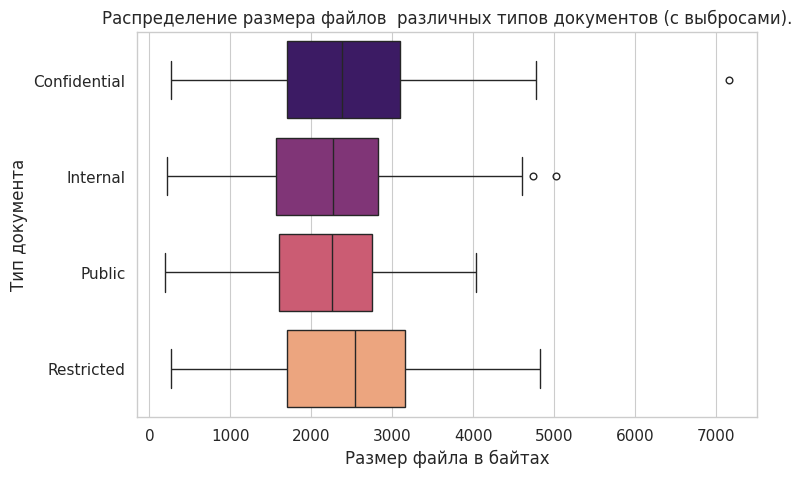

In [ ]:
plt.figure(figsize=(8, 5))

# Задание палитры.
palette_colors = ['blue', 'magenta', 'green', 'yellow']

#sns.boxplot(data=res_meta_dataframe, x="Размер", y="Тип", palette=palette_colors)
sns.boxplot(data=res_meta_dataframe, x="Размер", y="Тип", hue='Тип', palette='magma', legend=False)
plt.title("Распределение размера файлов  различных типов документов (с выбросами).")
plt.xlabel("Размер файла в байтах")
plt.ylabel("Тип документа")

plt.show()

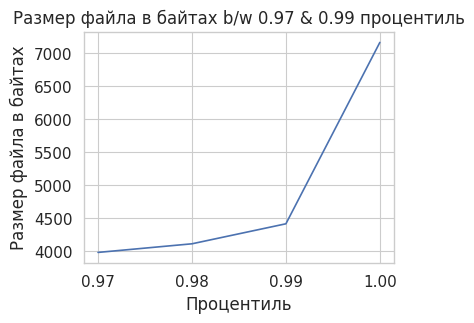

In [ ]:
# Обнаружение выбросов в размерах файлов с помощью метода Elbow
func_drawElbow(0.97, 1, "Размер", res_meta_dataframe, "Размер файла в байтах")

Наблюдения
99% документов имеют размер файла менее ~4.5 КБ.
Все документы с размером файла более 4.5 КБ можно считать выбросами.

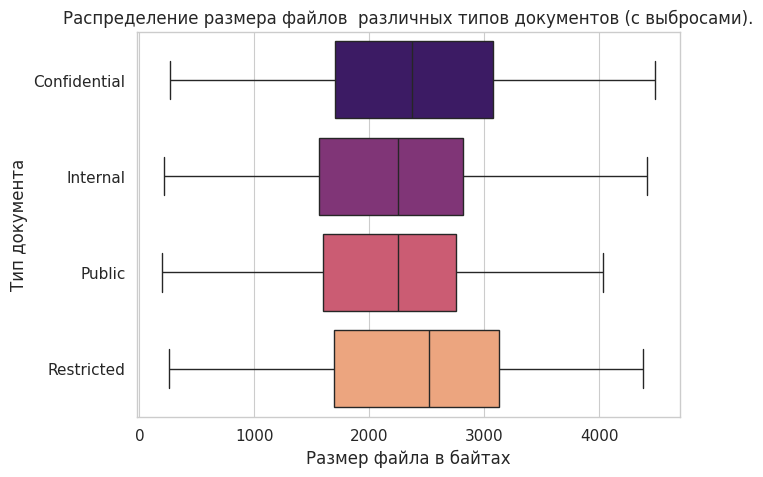

In [ ]:
filter_dataframe = res_meta_dataframe["Размер"] < 4_500

plt.figure(figsize=(7, 5))

sns.boxplot(data=res_meta_dataframe[filter_dataframe], x="Размер", y="Тип", hue='Тип', palette='magma', legend=False)
plt.title("Распределение размера файлов  различных типов документов (с выбросами).")
plt.xlabel("Размер файла в байтах")
plt.ylabel("Тип документа")

plt.show()

In [ ]:
gte_4_5_KB = round(len(res_meta_dataframe[~filter_dataframe]) / rows * 100, 1)
print(f"{gte_4_5_KB}% документов имеют рахмер более 4,5 Кб")

0.8% документов имеют рахмер более 4,5 Кб


**3. Обработка данных**

***3.1 Удаление выбросов***

In [ ]:
filter_dataframe = res_meta_dataframe["Размер"] > 4_500
outliers = res_meta_dataframe.loc[filter_dataframe, "Тип"].value_counts()
lost_docs = np.round(np.divide(outliers.values, types_count.values) * 100, 1)

func_plotAsTable(
    headers_loc=["Метка типа", "% потерянных данных на тип"],
    rows_loc=list(zip(types_count.index, lost_docs)),
    add_sl_no=True,
)

Номер типа,Метка типа,% потерянных данных на тип
1,Confidential,1.2
2,Restricted,1.0
3,Internal,1.0
4,Public,0.0


In [ ]:
res_meta_dataframe.drop(res_meta_dataframe[filter_dataframe].index, inplace=True)

rows_wo, cols_wo = res_meta_dataframe.shape  # wo :- количество документов без выбросов
print(f"Набор данных содержит {rows_wo} строк и {cols_wo} столбцов.")

Набор данных содержит 1208 строк и 5 столбцов.


***3.2 Извлечение и очистка текста документов***

In [ ]:
SPECIAL_CHARS = r"([^a-z0-9\s])\1+"
flags_ignorecase_multiline = re.IGNORECASE | re.MULTILINE

#===Функция предобработки текста
def func_preProcess(text_loc):
    # Замена подряд идущих специальных символов на пробел.
    res_text = re.sub(SPECIAL_CHARS, " ", text_loc, flags=flags_ignorecase_multiline)

    # Сжатие текста в одну строку путем  замены всех
    # лишних пробелов, \t, \n, \r и т.д. на один пробел.
    return re.sub(r"\s+", " ", res_text).strip()

In [ ]:
# Парсинг текста из файлов документов.
if os.path.exists(PARSED_TEXT_CSV):
    print("Загрузка текста документов из:", PARSED_TEXT_CSV)
    parsed_dataframe = pd.read_csv(PARSED_TEXT_CSV)
else:
    res_parsed_data = []
    for document_id, file_path in tqdm(res_meta_dataframe[["ID", "Путь"]].values):

        # Чтение документа в виде последовательности байт.
        with open(file_path, "rb") as txt_file:
            ip_text = txt_file.read().decode("utf-8", errors="ignore").strip()  # Ввод текста

            if func_isEmpty(ip_text):
                continue

            preprocessed_text = func_preProcess(ip_text)
            res_parsed_data.append([document_id, len(preprocessed_text), preprocessed_text])

    # Преобразование обработанный текст из документов в DataFrame.
    col_names = ["ID", "Размер текста", "Текст"]
    parsed_dataframe = pd.DataFrame(res_parsed_data, columns=col_names)

    # Сохранение DataFrame в CSV file для последующего использования.
    parsed_dataframe.to_csv(PARSED_TEXT_CSV, index=False, na_rep="")
    print("Обработанный текст сохранен в:", METADATA_CSV)

parsed_dataframe.head()

100%|██████████| 1208/1208 [05:47<00:00,  3.47it/s]


Обработанный текст сохранен в: /content/drive/My Drive/Data/preprocessed/metadata.csv


,ID,Размер текста,Текст
0,I_219,1387,MEMORANDUM To: All Department Heads From: Eva ...
1,I_196,2495,Subject: Coordination of New Partnership Strat...
2,I_205,2297,MEMORANDUM To: All Department Heads From: Kath...
3,I_215,2184,Subject: Coordination of Upcoming Marketing Ca...
4,I_203,2996,MEMORANDUM To: All Team Leaders From: Jane Doe...


**4. Предварительная языковая подготовка**

***4.1 Загрузка английской языковой модели***

In [ ]:
# Загрузка англоязычного конвейера.
english_nlp = spacy.load("en_core_web_sm")

english_nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

***4.2 Разработка функции языковой (английской) обработки***

In [ ]:
work_patterns = [
    {"patterns": [[{"TEXT": "'ve"}]], "attrs": {"LEMMA": "have"}},
    {"patterns": [[{"TEXT": "'m"}]], "attrs": {"LEMMA": "am"}},  # Не используется при длине < 3
    {"patterns": [[{"TEXT": "'re"}]], "attrs": {"LEMMA": "are"}},
]


def func_processLanguage(Id_loc, text_loc, flag_stop=True, flag_punctuation=True):
    """
    Функция языковой обработки, выполняющая
        1. Удаление стоп-слов и знаков препинания.
        3. Лемматизация токенов.
        3. Разделение сущностей.

    flag_stop :- Флаг для удаления стоп-слов.
    flag_punctuation :- Флаг для удаления знаков пунктуации.
    """

    document_content = english_nlp(str(text_loc))

    # Особые случаи деконструкции.
    atrib_rlr = english_nlp.get_pipe("attribute_ruler")
    atrib_rlr.add_patterns(work_patterns)

    # Предобработка на основе разделения.
    with document_content.retokenize() as retokenizer:
        for ent in document_content.ents:
            if ent.label_ in ["PERSON", "GPE", "ORG", "PRODUCT"]:
                new_val = "_".join(ent.text.split())
                retokenizer.merge(document_content[ent.start : ent.end], attrs={"LEMMA": new_val})

    # Лемматизация, удаление стоп-слов и знаков препинания.
    res_lemmas = []
    for token_current in document_content:
        if (flag_stop and token_current.is_stop) or (flag_punctuation and token_current.is_punct):
            continue

        res_lemmas.append(token_current.lemma_.strip().lower())

    lemmatizated_text = " ".join(res_lemmas)

    # Подсчет POS..
    pos_count = {"ID": Id_loc} if Id_loc else {}
    for item_current in sorted(document_content.count_by(spacy.attrs.POS).items(), key=lambda i: i[0]):
        pos_count[document_content.vocab[item_current[0]].text] = item_current[1]

    return lemmatizated_text, pos_count

***4.3 Деконструкция, Лемматизация и NER***

In [ ]:
if os.path.exists(DOCS_CSV):
    print("Загрузка обработанных языковых данных из:", DOCS_CSV)
    final_dataframe = pd.read_csv(DOCS_CSV)
else:
    # Форк parsed_dataframe DataFrame.
    language_dataframe = parsed_dataframe.copy()

    lemmatizated_texts = []
    pos_counts = []
    for doc_id, doc_text in tqdm(language_dataframe[["ID", "Текст"]].values):
        # Выполнение деконструкции, лемматизации и NER для каждой строки.
        lemmatizated_text, pos_count = func_processLanguage(doc_id, doc_text)
        lemmatizated_texts.append(lemmatizated_text)
        pos_counts.append(pos_count)

    language_dataframe["Текст"] = lemmatizated_texts

    # Объединение нижеуказанных DataFrames в один результирующий DataFrame:
    # 1. pos_dataframe :- DataFrame, содержащий количество частей речи в тексте.
    # 2. language_dataframe :- Информация из языкового конвейера.
    # 3. meta_dataframe :- DataFrame, содержащий метаданные файлов документов.
    pos_dataframe = pd.DataFrame(pos_counts).fillna(0)
    language_dataframe = language_dataframe.join(pos_dataframe.set_index("ID"), on="ID")
    final_dataframe = language_dataframe.join(res_meta_dataframe.set_index("ID"), on="ID")

    # Сохранение результирующего DataFrame в файл CSV.
    final_dataframe.to_csv(DOCS_CSV, index=False, na_rep="")

final_dataframe.head(2)

100%|██████████| 1208/1208 [01:13<00:00, 16.36it/s]


,ID,Размер текста,Текст,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,...,PROPN,PUNCT,SCONJ,VERB,X,SYM,Тип,Размер,Путь,Категория
0,I_219,1387,memorandum all_department_heads eva radosavlje...,5.0,14.0,3.0,6.0,6.0,8.0,2.0,...,46,32,2.0,14.0,3.0,0.0,Internal,1402,/content/drive/My Drive/Data/docs_ds/internal/...,0
1,I_196,2495,subject coordination new partnership strategie...,37.0,44.0,9.0,19.0,12.0,37.0,4.0,...,34,50,3.0,42.0,9.0,0.0,Internal,2508,/content/drive/My Drive/Data/docs_ds/internal/...,0


**5. EDA (анализ) текста документов**

***5.1 Результирующий набор данных***

In [ ]:
rows_final, columns_final = final_dataframe.shape
print(f"Результирующий набор данных содержит {rows_final} строк и {columns_final} столбцов.\n")

final_dataframe.info()

Результирующий набор данных содержит 1208 строк и 24 столбцов.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1208 entries, 0 to 1207
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   ID             1208 non-null   object  
 1   Размер текста  1208 non-null   int64   
 2   Текст          1208 non-null   object  
 3   ADJ            1208 non-null   float64 
 4   ADP            1208 non-null   float64 
 5   ADV            1208 non-null   float64 
 6   AUX            1208 non-null   float64 
 7   CCONJ          1208 non-null   float64 
 8   DET            1208 non-null   float64 
 9   INTJ           1208 non-null   float64 
 10  NOUN           1208 non-null   float64 
 11  NUM            1208 non-null   float64 
 12  PART           1208 non-null   float64 
 13  PRON           1208 non-null   float64 
 14  PROPN          1208 non-null   int64   
 15  PUNCT          1208 non-null   int64   
 16  SCONJ         

***5.2 Корреляционная матрица***

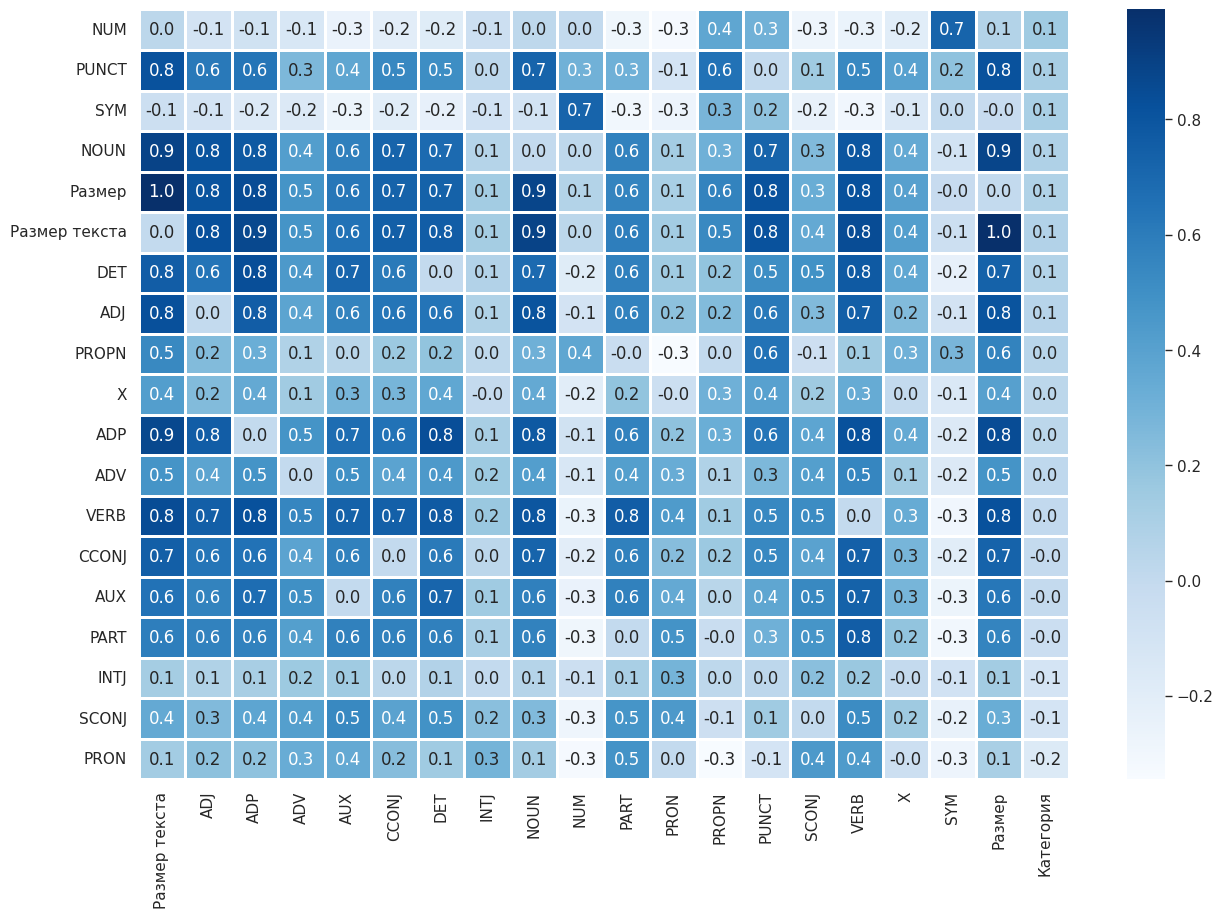

In [ ]:
correlation_matrix = func_getCorrMat(final_dataframe, "Категория")

plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="Blues", fmt=".1f", linecolor="white", linewidths=1)

plt.show()

***5.3 Одномерный анализ***

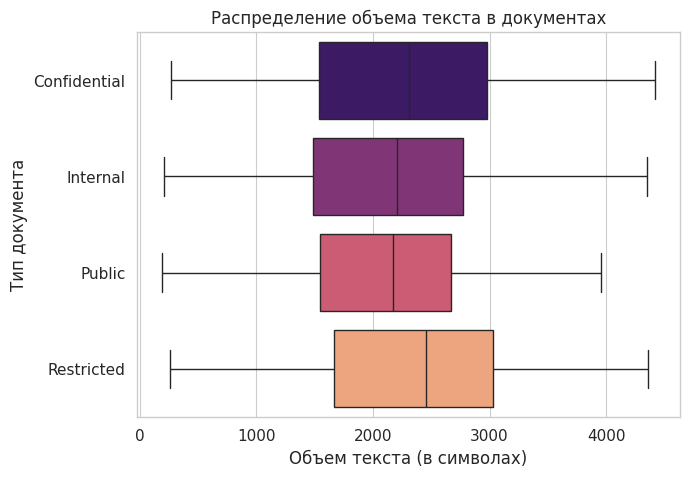

In [ ]:
plt.figure(figsize=(7, 5))

sns.boxplot(data=final_dataframe, x="Размер текста", y="Тип", hue='Тип', palette='magma', legend=False)
plt.xlabel("Объем текста (в символах)")
plt.ylabel("Тип документа")
plt.title("Распределение объема текста в документах")

plt.show()

***5.4 Двумерный анализ***

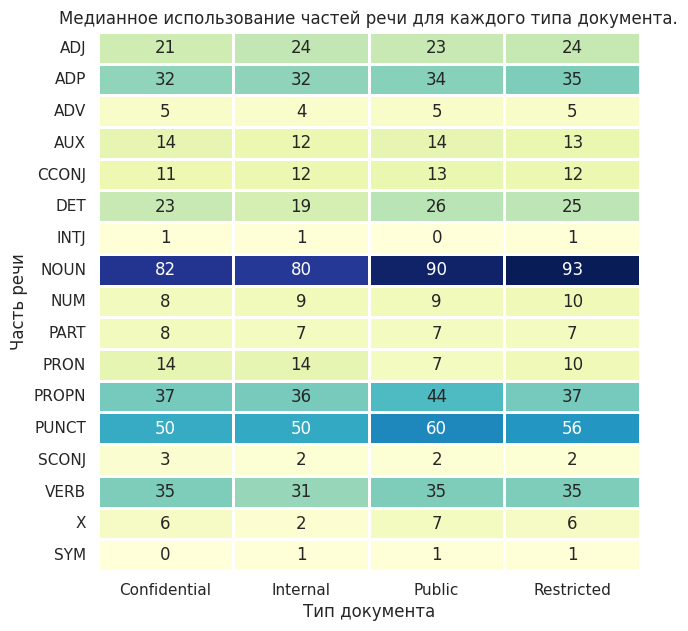

In [ ]:

pos_keys = final_dataframe.columns.tolist()[3:20]
final_dataframe[pos_keys] = final_dataframe[pos_keys].astype("int64")

aggregate_parameters = {k: (k, "median") for k in pos_keys}
mean_mat = final_dataframe[pos_keys + ["Категория"]].groupby("Категория").agg(**aggregate_parameters).T

plt.figure(figsize=(7, 7))
sns.heatmap(
    mean_mat,
    annot=True,
    cmap="YlGnBu",
    fmt=".0f",
    cbar=False,
    linecolor="white",
    linewidths=1,
    xticklabels=types_map.keys(),
)
plt.title("Медианное использование частей речи для каждого типа документа.")
plt.xlabel("Тип документа")
plt.ylabel("Часть речи")

plt.show()

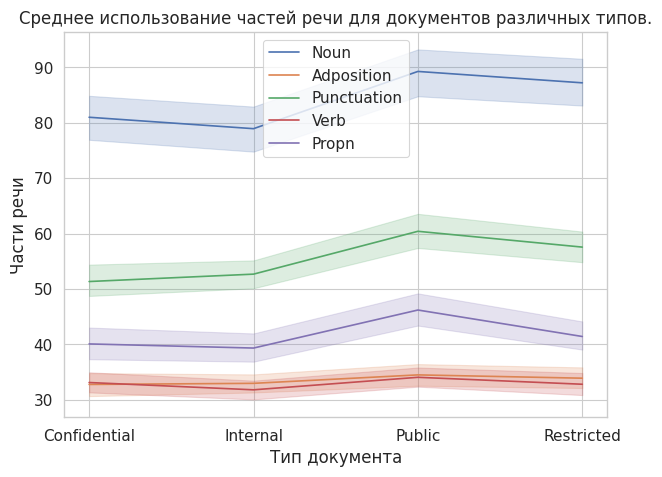

In [ ]:
plt.figure(figsize=(7, 5))

sns.lineplot(data=final_dataframe, x="Категория", y="NOUN", label="Noun")
sns.lineplot(data=final_dataframe, x="Категория", y="ADP", label="Adposition")
sns.lineplot(data=final_dataframe, x="Категория", y="PUNCT", label="Punctuation")
sns.lineplot(data=final_dataframe, x="Категория", y="VERB", label="Verb")
sns.lineplot(data=final_dataframe, x="Категория", y="PROPN", label="Propn")
plt.ylabel("Части речи")
plt.xlabel("Тип документа")
plt.title("Среднее использование частей речи для документов различных типов.")
plt.xticks(ticks=range(0, 4), labels=types_map.keys())

plt.show()

**6. Заключение**

In [ ]:
# Процент потерь в наборе данных после предварительной обработки.
total_loss = np.round((rows - rows_final) / rows * 100, 1)
print(str(total_loss) + "%")

0.8%
